# Kaggle challenge: histopathological cancer detection

https://github.com/pzirnhel/MSEE_Deep_Learning_Week_3.git

## Step 1: Introduction

One of the major successes of Deep Learning is with Convolutional Networks, which revolutionized computer vision. With subsequent iterations, Convolutional Networks were even able to surpass human performance in certain aspects of image classification. One such classification task is the identification of cancer in lymph nodes, for example in the context of breast cancer surgery (for the surgeon to decide whether or not to perform a traumatizing excision of axillary lymph nodes). Having a computer system capable of identifying disease in biopsies with a performance comparable to humans, especially if the system may run on a cell phone when doing inference (e. g. saying if this particular sample is pathological or not) is also a huge advantage in environments where resources are scarce.

To accomplish this feat, it is necessary to obtain a large number of images from biopsies and have them labeled by a pathologist as showing the presence of cancer or not. The frequency by which a biopsy is found to be positive should ideally reflect what is found in common practice, so that the repartition positive/negative samples would match this common practice distribution. In addition, there should be enough samples to allow a network to learn from the data with enough generality, rather than identify spurious patterns only present in the samples provided, but not generally. In practice, this means hundreds of thousands of labeled images. These data are being provided in this Kaggle challenge.

This notebook is subdivided in five parts. After the introduction, we first perform exploratory data analysis. Then comes a part about model iteration: we build a first iteration of a convolutional network, perform a hyperparameter search, use training and validation loss and accuracy curves to look for ways to improve the model. We get a first test score with Kaggle on this preliminary model. Then we implement another version, following the same procedure. We get the test score from Kaggle. The fourth part is about collecting and discussing the results, then comes a conclusion.

In this Jupyter notebook, after importing Pandas needed for manipulating the data, Numpy for matrix computations, Matplotlib.pyplot for visualizations, os to interact with the hard drive seemlessly and tensorflow with keras to implement neural networks, I start exploring the data, loaded from the Kaggle website. Specific modules for sklearn are imported later on an as needed basis to utilize specific functions: split the data or obtain the ROC curve for example. This notebook is informed by Rajat Garg’s [1] and Laurence Moroney's works [2]. The former articulated how to build a pipeline to train a keras network when the training data is too large to fit in Random Access Memory (RAM). The latter gave a more detailed course on convolutional neural networks using Tensorflow, which was invaluable. The data was compiled by [3].

In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import keras

Using TensorFlow backend.


#### The data

The data from Kaggle is represented by a "train" folder containing the training and validation set images, a "test" folder containing only images and a "train_labels.csv" file containing the training labels. In addition, a sample submission file is provided as a template: "sample_submission.csv". 

Let's start with the train folder. The walk method returns the explored folder path in the first item of a triplet ("dump1"), a list of subdirectories in the second item of the triplet ("dump2") and a list of file names in the third item: what we are interested in. The length of this list gives us the number of images in the folder.

In [2]:
train_im_names=[]
for dump1,dump2,files in os.walk('train'):
    for file in files:
        train_im_names.append(file)
m_train=len(train_im_names)
print(m_train)

220025


There are 220025 training and validation images

In [3]:
print(train_im_names[0])

00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif


Which are in a .tif format.

In [4]:
im=plt.imread('train/'+train_im_names[0])

In [5]:
print(im.shape)

(96, 96, 3)


In [6]:
print(im.dtype)

uint8


In [7]:
print(220025*96*96*3*5)

30416256000


Each pixel is encoded with 1 byte. The size of each image is 96 by 96 pixels and there are 3 Red Blue Gean channels, so each color image is represented by 3 images of 96 by 96 pixels. Once converted in 32 bit floats with a 2 byte mantiss (e. g. 5 bytes per float), these 220025 color images will represent about 30 GB of memory. This is way too big to fit into the 8 GB of RAM this old machine has.

## Step 2: exploratory data analysis

The consequence is the need to use a generator to feed the training and validation data to keras. The generator is a program that collects data stored on the hard drive and makes a batch with it. It is an iterator object, collecting a different set until it has gone through all the data and then it resets.

Let's now look at the labels, which Kaggle provides as a .csv file named "train_labels.csv".

In [8]:
df_train=pd.read_csv("train_labels.csv")
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
id       220025 non-null object
label    220025 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None


In [9]:
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [10]:
print(train_im_names[:5])

['00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif', '000020de2aa6193f4c160e398a8edea95b1da598.tif', '00004aab08381d25d315384d646f5ce413ea24b1.tif', '0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif', '0000da768d06b879e5754c43e2298ce48726f722.tif']


Looking at the orders of the image names in the training folder and in the dataframe, it becomes obvious these two orders are different. Therefore it is necessary to identify, using the dataframe which label matches each image in the train folder.

However, it is also possible, a priori, that not all images are accounted for: there may be images with no label or duplicate images with the same label. So we need to comb through the data to verify this is not the case and if so, we would have to fix it. 

The following function accomplishes both of these. It first ranks each image by id, since the ids are hexadecimal numbers, in the train folder and in the dataframe. Then it verifies each image in the train folder has its match in the dataframe: there are no duplicates and all images have labels. Then it uses this ranking to find the label in the dataframe that matches each image in the training folder.

Conclusion: no need for cleaning the data, just to match each image with its proper label.

In [11]:
def get_labels(image_names_list,df):
    n_samples=len(image_names_list)
    # 1. Get lists of image ids as numbers for images referenced in the folder and images referenced in the dataframe
    tif_image_numbers=[]
    csv_image_numbers=[]
    for sample in range(n_samples):
        tif_image_numbers.append(int(image_names_list[sample].split('.')[0],16))
        csv_image_numbers.append(int(df['id'][sample],16))
    # 2. Sort these images by id numbers
    csv_order=sorted(range(n_samples),key=csv_image_numbers.__getitem__)
    tif_order=sorted(range(n_samples),key=tif_image_numbers.__getitem__)
    # 3. In the same loop, assert images ids match one by one and get a table of rankings for each image in the folder
    tif_rank=np.zeros([n_samples],np.int32)
    for idx in range(n_samples):
        assert csv_image_numbers[csv_order[idx]]==tif_image_numbers[tif_order[idx]], "Numbers do not match"
        tif_rank[tif_order[idx]]=idx
    # 4. Get the labels associated with each image in the folder
    labels=np.zeros([n_samples],np.int32)
    for idx in range(n_samples):
        labels[idx]=df['label'][csv_order[tif_rank[idx]]]
    return labels


In [12]:
train_labels=get_labels(train_im_names,df_train)

Let's now look at how balanced the data is. If the data is too unbalanced (e. g. many more positive examples than negative or vice versa), we would have to sample it differently.

In [13]:
#Number of positive samples
print(np.sum(train_labels))
#Compared to the number of samples
print(m_train)
#Percentage
100*np.sum(train_labels)/m_train

89117
220025


40.503124644926714

So there are 89,117 positive samples out of 220025, which represents about 40.5 % of the data. Fortunately, the data is not too unbalanced. Let's see how this looks on a histogram.

In [14]:
counts_per_label=df_train.groupby('label')['label'].count()
print(counts_per_label)

label
0    130908
1     89117
Name: label, dtype: int64


<BarContainer object of 2 artists>

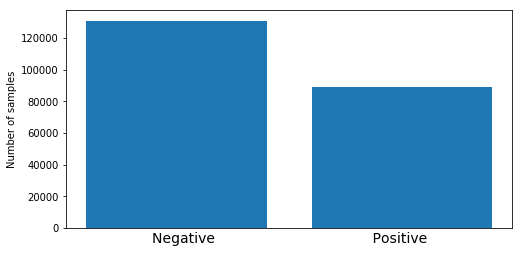

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.set_xticks([])
ax.set_xlabel("Negative                                   Positive", fontsize=14)
ax.set_ylabel("Number of samples")
plt.bar(counts_per_label.index,counts_per_label.values)

In [16]:
del df_train

This frees some RAM.

Time to look at the "test" folder and see if the images, see how many there are and if they are also in a different order than the order required for submission.

In [17]:
test_im_names=[]
for dump1,dump2,files in os.walk('test'):
    for file in files:
        test_im_names.append(file)
m_test=len(test_im_names)
print(m_test)

57458


In [18]:
print(57458*96*96*3*5)

7942993920


There are 57458 test images, which when converted to 32 bit floats represent about 7.9 GB of RAM. Although it is under 8 GB, given the memory requirements of the network itself, for example, its weights, this will be too large to fit in memory too.

So, similarly to the training data, we will need to batch the predictions: obtain predictions for one batch at a time. The use of a generator for predictions in keras is deprecated. So we will simply use the .predict method instead on each batch.

Now let us look at the order of the images in the "test" folder and compare it to the order in the dataframe to be used to submit predictions to Kaggle.

In [19]:
df_test=pd.read_csv("sample_submission.csv")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
id       57458 non-null object
label    57458 non-null int64
dtypes: int64(1), object(1)
memory usage: 897.9+ KB
None


In [20]:
df_test.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [21]:
print(test_im_names[:10])

['00006537328c33e284c973d7b39d340809f7271b.tif', '0000ec92553fda4ce39889f9226ace43cae3364e.tif', '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif', '000253dfaa0be9d0d100283b22284ab2f6b643f6.tif', '000270442cc15af719583a8172c87cd2bd9c7746.tif', '000309e669fa3b18fb0ed6a253a2850cce751a95.tif', '000360e0d8358db520b5c7564ac70c5706a0beb0.tif', '00040095a4a671280aeb66cb0c9231e6216633b5.tif', '000698b7df308d75ec9559ef473a588c513a68aa.tif', '0006e1af5670323331d09880924381d67d79eda0.tif']


Similarly to the training data, the samples are ordered differently. However, compared to to the training data there is no need to check that each image in the submission dataframe has a label, since the labels, or rather the probabilities of cancer presence is what we have to provide to Kaggle. There is only a need to check each sample image name in the submission dataframe template has its unique equivalent in the "test" directory. 

Although we could do this now, we decide to postpone this verification until after the network training, because we need the memory. When redacting this notebook, the verification had already been done: each image in the submission dataframe is accounted for by a unique image in the "test" folder. We will show that later.

No data cleaning needed either.

For now let us free memory and delete the submission dataframe.

In [22]:
del df_test

#### Plan for analysis

Given that the best current method to classify images is to use a convolutional network, we will implement such a network. We will start with a rather generic convolutional net, then modify its architecture in order to improve metrics. The two metrics we will use are validation accuracy and Area Under the ROC curve (see below).

Based on the above considerations we will need to keep the data on the hard drive and only import one batch at a time when training the network and computing the validation accuracy.

## Step 3: Model architecture iterations

Time to start training models. 

### Initial model: preliminary considerations

The first step is to shuffle the data of the "train" folder, then split it into training and validation sets. The validation set is used to adjust the hyperparameters. In the first iteration, it will be used to essentially determine when to stop training, using early stopping as a regularization technique. 

To shuffle and to split, we use the corresponding sklearn methods:

In [23]:
from sklearn.utils import shuffle

image_names_shuffled,labels_shuffled=shuffle(train_im_names,train_labels)

In order to keep the validation data in memory, it needs to be small enough as to leave enough room for the network parameters and intermediate tensors. Below is a quick search to find how much to split off the training data. Given that $220025=5*5*13*677$, setting aside $677*5=3385$ 32 bit floats images amounts to almost half a gigabyte, which is why we set the split to $3385/220025$. This leaves: $220025-3385 = 64 * 3385$ images for training. We therefore choose a batch size of 64, and since 3385 is divisible by 5, we set the number of steps associated with the validation data to 5.

In [24]:
from sklearn.model_selection import train_test_split
v_split=3385/220025
X_train_im_names,X_val_im_names,l_train,l_val=train_test_split(np.array(image_names_shuffled),labels_shuffled,test_size=v_split)

The next step is to build a generator program, which is an iterator which will fetch the data in batches from the hard drive.

This one inherits from the Sequence class of the keras.utils keras module. The "\__len\__" method provides the iterator the number of iterations before it resets: number of images divided by batch_size. The "\__getitem\__" method gets called by the .fit_generator function during training every time a new batch is needed. Its role is to provide a batch of images and their corresponding training labels. 

Note that in the process, the image is read by matplotlib.pyplot.imread, reshaped using numpy.reshape into a tensor of 96 by 96 pixels and 3 Red Blue Green channels, each pixel value is scalled from 0 to 255 to 0 to 1, which involves a conversion to 32 bit floats and finally fed, along with the labels, as a numpy array to .fit_generator.

In [25]:
class MyGenerator(keras.utils.Sequence):
    def __init__(self,im_names,l,batch_size):
        self.im_names=im_names
        self.l=l
        self.batch_size=int(batch_size)
        
    def __len__(self):
        return len(self.im_names)//self.batch_size
    
    def __getitem__(self,idx):
        batch_im=self.im_names[idx*self.batch_size:(idx+1)*batch_size]
        batch_l=self.l[idx*self.batch_size:(idx+1)*batch_size]
        return np.array([np.reshape(plt.imread('train/'+im_name),[96,96,3]) for im_name in batch_im])/255.0,batch_l

Now we have distinct training and validation sets, we rename the number of training samples as to correspond to the training set and similarly with the validation set. Let us verify the numbers above.

In [26]:
m_train=len(X_train_im_names)
m_val=len(X_val_im_names)
print("Number of training samples")
print(m_train)
print("Number of validation samples")
print(m_val)
print("This verifies that 5*5*13*677=220025")
print(5*5*13*677)
print("This verify that 64*677*5 is the number of training samples")
print(64*677*5)
print("This verify that 677*5 is the number of validation samples")
print(677*5)
print("They take up : "+str(677*5*96*96*3*5)+ " bytes of memory")
print("So we use a batch size of 64")
batch_size=64

Number of training samples
216640
Number of validation samples
3385
This verifies that 5*5*13*677=220025
220025
This verify that 64*677*5 is the number of training samples
216640
This verify that 677*5 is the number of validation samples
3385
They take up : 467942400 bytes of memory
So we use a batch size of 64


The number of test samples, on the other hand, is not divisible by the batch size. Oh well, the last batch will just have to be a tiny bit smaller.

In [27]:
print(str(m_test/batch_size)+" is decimal")
print("So we will use "+str(m_test//batch_size)+" batches plus a small batch of "+str(m_test%batch_size))

897.78125 is decimal
So we will use 897 batches plus a small batch of 50


In [28]:
train_generator=iter(MyGenerator(X_train_im_names,l_train,batch_size))

In [29]:
val_data=np.array([np.reshape(plt.imread('train/'+im_name),[96,96,3]) for im_name in X_val_im_names],np.float32)/255.0
print(val_data.dtype)

float32


### Initial model: architecture

Now we instantiate a model. In the Coursera class about convolutions this writer took earlier, Conv2D layers were typically followed by 2 by 2 MaxPooling layers, so I kept this arrangement and replicated it 3 times. As we move up the layer hierarchy, the "field of view" increases, so it makes sense to use more kernels as the information encompassed is larger: hence 16 for the first Conv2 layer, 32 for the second and 64 for the third. Using kernel sizes of (3,3) is preferable as underlined by Pr. Kim, as it uses less memory. Relu functions are better than sigmoids to allow gradients to flow.

This feature extractor stage is followed by a classifier with, after flattening the feature extractor input, is just a two layer classifier with one dense layer with Relu activation function and an output layer with a sigmoid activation function. The latter is justified, because the ouput is binary. A sigmoid function adequately models a Bernoulli random variable conditioned inputs values ranging from minus to plus infinity. It follows the corresponding loss is the binary cross-entropy. 

Finally, this first iteration contains no regularizers such as Dropout and Batch Normalization and uses all the image, even though the Kaggle challenge is about looking for cancer only in the 32 by 32 pixels at the center of the image. 

There is a case to make that including the whole image may improve classification as the presence of cancer cells outside of the center window informs its presence in the center. 

The plan is to deal with modifications in a second iteration, after a hyperparameter search.

So, because there will be several iterations, we will store the results of these iterations in a measurement table. In particular, we are interested in the validation accuracy, the Area Under the Curve (AUC) for the Receiver Operating Characteristic (ROC) curve and the test AUC provided by Kaggle when submitting: they are entered manually.

In [30]:
measurements=np.zeros([3,3])

In [60]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
#model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['acc'])

Not shown here. Adam was tried as an optimizer, but loss was nan and training accuracy kept going down

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 94, 94, 16)        448       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 6400)              0         
__________

In [62]:
history0=model.fit_generator(generator=train_generator,steps_per_epoch=m_train//batch_size,epochs=5,verbose=1,shuffle=True,
                            validation_data=(val_data,l_val),validation_steps=5)

Epoch 1/5
3385/3385 [==============================] - 164s 48ms/step - loss: 0.4375 - acc: 0.8001 - val_loss: 0.3581 - val_acc: 0.8449
Epoch 2/5
3385/3385 [==============================] - 155s 46ms/step - loss: 0.3427 - acc: 0.8532 - val_loss: 0.3316 - val_acc: 0.8549
Epoch 3/5
3385/3385 [==============================] - 154s 45ms/step - loss: 0.3121 - acc: 0.8705 - val_loss: 0.3159 - val_acc: 0.8718
Epoch 4/5
3385/3385 [==============================] - 151s 45ms/step - loss: 0.3038 - acc: 0.8760 - val_loss: 0.2972 - val_acc: 0.8786
Epoch 5/5
3385/3385 [==============================] - 152s 45ms/step - loss: 0.3120 - acc: 0.8740 - val_loss: 0.2934 - val_acc: 0.8801


Following are curves for training and validation losses first, then training and validation accuracy.

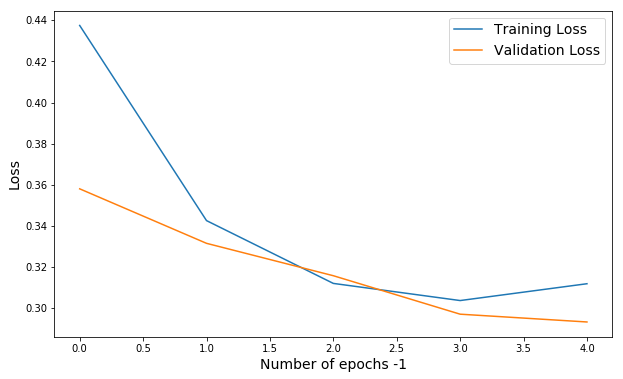

In [66]:
train_loss=history0.history['loss']
val_loss=history0.history['val_loss']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend(loc="upper right", fontsize=14)

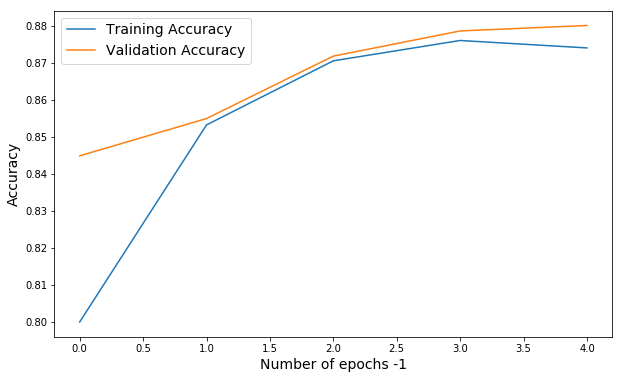

In [67]:
train_acc=history0.history['acc']
val_acc=history0.history['val_acc']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.legend(loc="upper left", fontsize=14)

The validation curves above look very jagged. This suggests a learning rate that is too high. We need to find a learning rate that is lower, but not so low as to stall learning. As the learning rate gets lower, it will require more epochs so we increase the number of epochs as we lower the learning rate. We will also keep RMSprop.

### Intial model: metrics and hyperparameter tuning

Below is a function searching for the best optimizer and the best learning rate. First we collect the histories, then examine the learning and validation curves one history at a time.

In [43]:
histories=[]
opt=[tf.keras.optimizers.RMSprop(lr=0.0005),tf.keras.optimizers.RMSprop(lr=0.0001),tf.keras.optimizers.RMSprop(lr=0.00005)]
n_epochs=[10,10,15]
for idx in range(3):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=opt[idx],loss='binary_crossentropy',metrics=['acc'])
    history=model.fit_generator(generator=train_generator,steps_per_epoch=m_train//batch_size,epochs=n_epochs[idx],verbose=1,
                                shuffle=True,validation_data=(val_data,l_val),validation_steps=5)
    histories.append(history)
        

Epoch 1/10
3385/3385 [==============================] - 151s 45ms/step - loss: 0.4425 - acc: 0.7981 - val_loss: 0.3770 - val_acc: 0.8269
Epoch 2/10
3385/3385 [==============================] - 151s 45ms/step - loss: 0.3544 - acc: 0.8472 - val_loss: 0.3680 - val_acc: 0.8366
Epoch 3/10
3385/3385 [==============================] - 150s 44ms/step - loss: 0.3233 - acc: 0.8647 - val_loss: 0.3407 - val_acc: 0.8514
Epoch 4/10
3385/3385 [==============================] - 150s 44ms/step - loss: 0.3055 - acc: 0.8740 - val_loss: 0.3339 - val_acc: 0.8585
Epoch 5/10
3385/3385 [==============================] - 150s 44ms/step - loss: 0.2944 - acc: 0.8807 - val_loss: 0.3257 - val_acc: 0.8629
Epoch 6/10
3385/3385 [==============================] - 150s 44ms/step - loss: 0.2865 - acc: 0.8850 - val_loss: 0.3201 - val_acc: 0.8691
Epoch 7/10
3385/3385 [==============================] - 149s 44ms/step - loss: 0.2830 - acc: 0.8873 - val_loss: 0.3113 - val_acc: 0.8724
Epoch 8/10
3385/3385 [===================

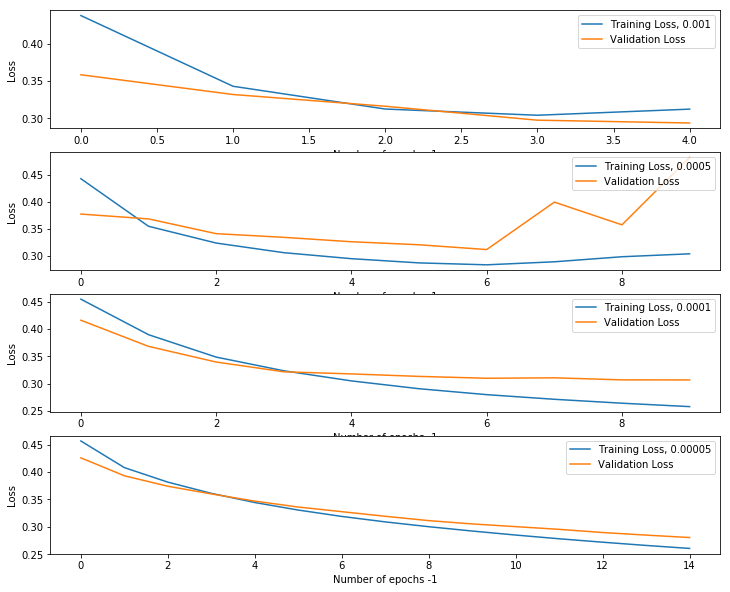

In [68]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12,10))
learning_rates=["0.001","0.0005","0.0001","0.00005"]
axs[0].plot(train_loss,label='Training Loss, '+learning_rates[0])
axs[0].plot(val_loss,label='Validation Loss')
axs[0].set_xlabel("Number of epochs -1", fontsize=10)
axs[0].set_ylabel("Loss", fontsize=10)
axs[0].legend(loc="upper right", fontsize=10)
for idx in range(1,4):
    axs[idx].plot(histories[idx-1].history['loss'],label='Training Loss, '+learning_rates[idx])
    axs[idx].plot(histories[idx-1].history['val_loss'],label='Validation Loss')
    axs[idx].set_xlabel("Number of epochs -1", fontsize=10)
    axs[idx].set_ylabel("Loss", fontsize=10)
    axs[idx].legend(loc="upper right", fontsize=10)


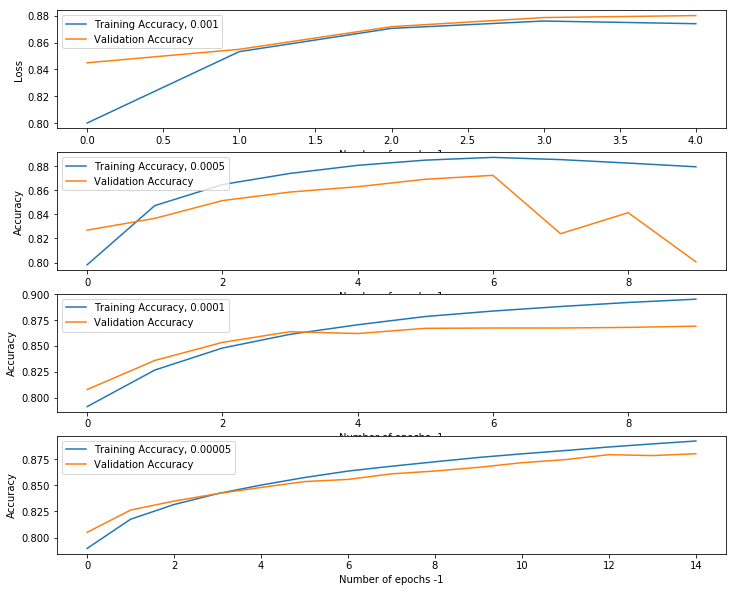

In [69]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12,10))
learning_rates=["0.001","0.0005","0.0001","0.00005"]
axs[0].plot(train_acc,label='Training Accuracy, '+learning_rates[0])
axs[0].plot(val_acc,label='Validation Accuracy')
axs[0].set_xlabel("Number of epochs -1", fontsize=10)
axs[0].set_ylabel("Loss", fontsize=10)
axs[0].legend(loc="upper left", fontsize=10)
for idx in range(1,4):
    axs[idx].plot(histories[idx-1].history['acc'],label='Training Accuracy, '+learning_rates[idx])
    axs[idx].plot(histories[idx-1].history['val_acc'],label='Validation Accuracy')
    axs[idx].set_xlabel("Number of epochs -1", fontsize=10)
    axs[idx].set_ylabel("Accuracy", fontsize=10)
    axs[idx].legend(loc="upper left", fontsize=10)

In [78]:
init_histories=np.array([history0.history['loss'],history0.history['val_loss'],
                        history0.history['acc'],history0.history['val_acc']])
for idx in range(3):
    init_histories=np.concatenate([init_histories,np.array([histories[idx].history['loss'],
                                                            histories[idx].history['val_loss'],
                                                            histories[idx].history['acc'],
                                                            histories[idx].history['val_acc']])],axis=1)
#np.save('init_histories.npy',init_histories)
# For memories: epoch number were 5, 10, 10 and 15

Looking at the validation loss and accuracy, it appears like the most important variations happened with a learning rate of 0.001, the first model tried. An initial learning rate decreased to 0.0005 helped, but the variations persist. For a learning rate of 0.0001, they disappear, but the validation loss appears to plateau. The best results are for the lowest rate of 0.00005: the validation loss is smoothe and continues to decrease.

The network does not show evidence of overfitting. However it may be good to train for a longer time with the lowest learning rate, as both training and validation losses appear to continue to go down. Let's train the model again with 20 epochs.

In [83]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.00005), loss='binary_crossentropy', metrics=['acc'])
history4=model.fit_generator(generator=train_generator,steps_per_epoch=m_train//batch_size,epochs=20,verbose=1,shuffle=True,
                            validation_data=(val_data,l_val),validation_steps=5)

Epoch 1/20
3385/3385 [==============================] - 163s 48ms/step - loss: 0.4562 - acc: 0.7904 - val_loss: 0.4364 - val_acc: 0.8006
Epoch 2/20
3385/3385 [==============================] - 153s 45ms/step - loss: 0.4196 - acc: 0.8113 - val_loss: 0.4120 - val_acc: 0.8127
Epoch 3/20
3385/3385 [==============================] - 152s 45ms/step - loss: 0.3944 - acc: 0.8244 - val_loss: 0.3938 - val_acc: 0.8204
Epoch 4/20
3385/3385 [==============================] - 151s 44ms/step - loss: 0.3734 - acc: 0.8356 - val_loss: 0.3739 - val_acc: 0.8295
Epoch 5/20
3385/3385 [==============================] - 149s 44ms/step - loss: 0.3536 - acc: 0.8453 - val_loss: 0.3566 - val_acc: 0.8446
Epoch 6/20
3385/3385 [==============================] - 149s 44ms/step - loss: 0.3372 - acc: 0.8538 - val_loss: 0.3433 - val_acc: 0.8514
Epoch 7/20
3385/3385 [==============================] - 150s 44ms/step - loss: 0.3232 - acc: 0.8608 - val_loss: 0.3321 - val_acc: 0.8561
Epoch 8/20
3385/3385 [===================

We trained the network using the validation accuracy, but the Kaggle competition uses a different metric: the ROC curve, which is computed from the prediction probabilities rather than the percentage of correct classification. The ROC curve is the mean of the prediction probabilities for the positive samples. Prediction probabilities for the positive samples are ranked from lowest to highest to get the ROC curve, which is normally only done with the positive samples. Kaggle provides a privacy score: the mean over the first 51% is the private score, and a public score: the mean over the last 49% is the public score. However, when examining how the weighted sum compares to the AUC, it is much lower for the test data than the validation data. Kaggle also talks about using "the predicted probabilities", not just the ones for positive samples. It is possible that they use also $1-predicted\ probability$ for the negative samples, rank all the probabilities then plot them to get a curve whose mean they compute as the score. Unfortunately, the website does not provide enough details about the metrics calculation, except that a score of 1 is a perfect score and the higher the score the better. Here we will simply report the weighted mean. The choice of using the AUC is because the neural net is designed to be part of a medical test. In such designs, it is worse to have poor sensitivity than poor specificity: we want the false negatives to be low even if the false positives get higher. In cancer, it is often more important to treat someone who may not have cancer than miss a patient with cancer. Although both are bad, the former is often preferable.

The ROC curve gives the ratio of true positives on the y axis in proportion of the false positive cutoff for yes/no cancer. If the false positive is cutoff low (the left of the curve), the proportion of people testing positive will also be low: the test will be less sensitive, but more specific. Conversely, if the cutoff is high (at the right of the curve), the proportion of people testing positive will be high: the test will be more sensitive, but less specific.

In [84]:
ypp=model.predict(val_data)[:,0]

In [89]:
# From the history, we get the validation accuracy in the end of training
measurements[0,0]=history4.history['val_acc'][19]
#measurements[0,0]=np.mean(np.float32(np.equal(np.int32(ypp+0.5),l_val)))
print(measurements[0,0])

0.88360413587604


Text(0.4,0.2,'AUC: 0.953778140885984')

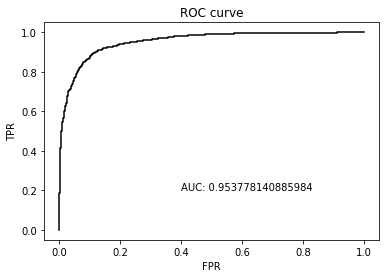

In [86]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr,tpr,thresholds = roc_curve(l_val,ypp)
auc=roc_auc_score(l_val,ypp)
plt.plot(fpr,tpr,'k-')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.4,0.2,'AUC: '+str(auc))

In [87]:
#measurements[0,1]=auc

Overall the best test is one which can have a low false positive cutoff, yet still detect almost all the true positives: the one with a largest area under the curve. Here a cutoff of 0.6, with 60% of false positives, will miss about 5 % of cancers, when a cutoff of 0.2 will miss about 10%. This is not a good test!

This is what the validation data predicts, using the validation set generator when iterating over the entire validation set. Below is the same thing, not using a generator. In both cases we use the .predict method of keras.Model, computing predictions one batch after another. The visualization of second way is just to show a generator is not needed. Hence the predictions for the test data are computed without using a generator. 

#### Computing predictions on the test set then submit to Kaggle

First, let us compute the predictions for the images on the "test" folder. As explained previously, we use 883 batches of 65 plus one batch of 63.

In [88]:
ypp=np.zeros([m_test])
X_test_im_names=np.array(test_im_names)
for batch in range(m_test//batch_size):
    batch_im=X_test_im_names[batch*batch_size:(batch+1)*batch_size]
    current_batch=np.array([np.reshape(plt.imread('test/'+im_name),[96,96,3]) for im_name in batch_im])/255.0
    ypp[batch*batch_size:(batch+1)*batch_size]=model.predict(current_batch)[:,0]
batch=m_test//batch_size
batch_im=X_test_im_names[batch*batch_size:m_test]
current_batch=np.array([np.reshape(plt.imread('test/'+im_name),[96,96,3]) for im_name in batch_im])/255.0
ypp[batch*batch_size:m_test]=model.predict(current_batch)[:,0]

Let's reload the sample submission dataframe.

In [90]:
df_test=pd.read_csv("sample_submission.csv")

Then as promised earlier, verify each image in this dataframe has its equivalent in the "test" folder.
And finally get the predictions in the order of the sample submission dataframe.

In [30]:
def get_csv_preds(image_names_list,df,ypp):
    n_samples=len(image_names_list)
    # 1. Get lists of image ids as numbers for images referenced in the folder and images referenced in the dataframe
    tif_image_numbers=[]
    csv_image_numbers=[]
    for sample in range(n_samples):
        tif_image_numbers.append(int(image_names_list[sample].split('.')[0],16))
        csv_image_numbers.append(int(df['id'][sample],16))
    # 2. Sort these images by id numbers
    csv_order=sorted(range(n_samples),key=csv_image_numbers.__getitem__)
    tif_order=sorted(range(n_samples),key=tif_image_numbers.__getitem__)
    # 3. In the same loop, assert images ids match one by one and get a table of rankings for each image in the folder
    csv_rank=np.zeros([n_samples],np.int32)
    for idx in range(n_samples):
        assert csv_image_numbers[csv_order[idx]]==tif_image_numbers[tif_order[idx]], "Numbers do not match"
        csv_rank[csv_order[idx]]=idx
    # 4. Get the labels associated with each image in the folder
    preds=np.zeros([n_samples])
    for idx in range(n_samples):
        preds[idx]=ypp[tif_order[csv_rank[idx]]]
    return preds

In [92]:
csv_preds=get_csv_preds(test_im_names,df_test,ypp)

The following code synthesizes a dataframe, then we save it to the hard drive as a .csv file for submission to Kaggle

In [93]:
df_y_test = pd.DataFrame(csv_preds,index=np.arange(len(df_test)),columns=['label'])
test_pred_df=pd.DataFrame(pd.concat([df_test.id,df_y_test],axis=1),index=df_test.index)
test_pred_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.075633
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.845373
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.000095
3,2c35657e312966e9294eac6841726ff3a748febf,0.277677
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.398248


In [94]:
#Save the file to the hard drive
#test_pred_df.to_csv('Lymph_Node_Invasion_my_solutionV2.csv',index=False)

In [ ]:
# Clear the memory for the new iteration
del df_y_test
del df_test
del test_pred_df

In [95]:
init_history4=np.array([history4.history['loss'],history4.history['val_loss'],
                        history4.history['acc'],history4.history['val_acc']])
#np.save('init_history4.npy',init_history4)

In [1]:
#measurements[0,2]=0.8732*0.51+0.9399*0.49
#print(measurements[0,2])

0.905883


The result returned by Kaggle is 0.905883.

Conclusion: the test developed with this network is not good. No surprise there. There is very little evidence of overfitting, but on the other hand, the model lacks expressivity. 

### Second iteration

So for this second iteration, we will use a larger model. More specifically, we will add a second feature extractor convolutional network in parallel to this first one, flatten the output, concatenate it with the one of the first network and feed it to a classifier. We also add a Batch Normalization layer after the concatenation to normalize the features.

In [31]:
inputs=tf.keras.Input(shape=(96, 96, 3))
x1a=tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3))(inputs)
x2a=tf.keras.layers.MaxPooling2D(2, 2)(x1a)
x3a=tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x2a)
x4a=tf.keras.layers.MaxPooling2D(2, 2)(x3a)
x5a=tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x4a)
x6a=tf.keras.layers.MaxPooling2D(2, 2)(x5a)
x7a=tf.keras.layers.Flatten()(x6a)
x1b=tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3))(inputs)
x2b=tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x1b)
x3b=tf.keras.layers.MaxPooling2D(2, 2)(x2b)
x4b=tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x3b)
x5b=tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x4b)
x6b=tf.keras.layers.MaxPooling2D(2, 2)(x5b)
x7b=tf.keras.layers.Flatten()(x6b)
x8=tf.keras.layers.Concatenate(axis=1)([x7a,x7b])
x9=tf.keras.layers.BatchNormalization()(x8)
x10=tf.keras.layers.Dense(512, activation='relu')(x9)
outputs=tf.keras.layers.Dense(1, activation='sigmoid')(x10)

model2=tf.keras.Model(inputs=inputs,outputs=outputs)
model2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.00005), loss='binary_crossentropy', metrics=['acc'])
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 94, 94, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 94, 94, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 47, 47, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (

In [32]:
history5=model2.fit_generator(generator=train_generator,steps_per_epoch=m_train//batch_size,epochs=5,verbose=1,shuffle=True,
                            validation_data=(val_data,l_val),validation_steps=5)

Epoch 1/5
3385/3385 [==============================] - 1469s 434ms/step - loss: 0.3964 - acc: 0.8246 - val_loss: 0.3521 - val_acc: 0.8514
Epoch 2/5
3385/3385 [==============================] - 1408s 416ms/step - loss: 0.3089 - acc: 0.8707 - val_loss: 0.3649 - val_acc: 0.8431
Epoch 3/5
3385/3385 [==============================] - 254s 75ms/step - loss: 0.2409 - acc: 0.9066 - val_loss: 0.3698 - val_acc: 0.8411
Epoch 4/5
3385/3385 [==============================] - 249s 73ms/step - loss: 0.1744 - acc: 0.9408 - val_loss: 0.4121 - val_acc: 0.8292
Epoch 5/5
3385/3385 [==============================] - 249s 74ms/step - loss: 0.1135 - acc: 0.9680 - val_loss: 0.5135 - val_acc: 0.8074


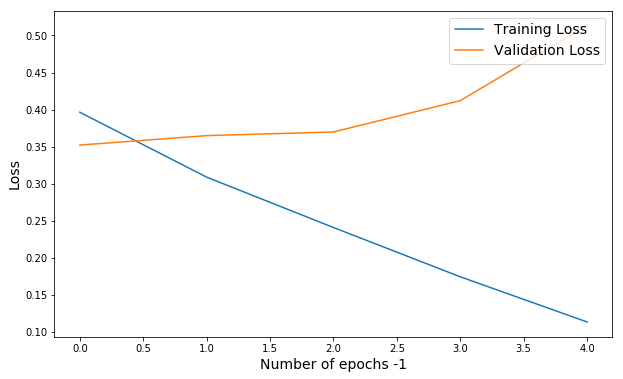

In [33]:
train_loss=history5.history['loss']
val_loss=history5.history['val_loss']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend(loc="upper right", fontsize=14)

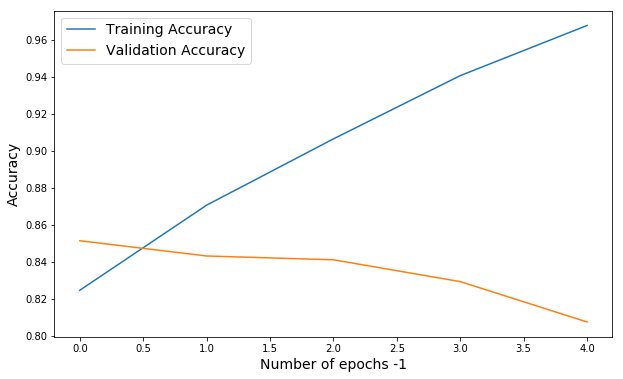

In [34]:
train_acc=history5.history['acc']
val_acc=history5.history['val_acc']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.legend(loc="upper left", fontsize=14)

Training for 5 epochs showed that again, the initial learning rate may be too high: even though the training loss and training accuracy both improve with training, the validation loss and the validation accuracy diverge. Let's try again with an initial learning rate five times lower.

Alternatively, this pattern may be due to overfitting. After all, we doubled the number of parameters. Let's also try to mitigate overfitting.

The best strategy to deal with this problem is to get more data: fortunately, this is possible. Simply by flipping the images (e. g. using the mirror image of a sample image for training in addition to the original) and adding them to the training set, given that the images contain no text. One alternative way to think of this is by imagining that the histologic preparation consists of cutting ultrathin slices of tissue: it does not matter if we look at the original side of the slice of tissue or its flip side as far as cancer diagnosis is concerned. We may even consider flipping the image upside-down, although in this case how the image is lit may matter.

We will hold off using Dropout and more Batch Normalization for now, until we see if the network continues to overfit. 


In [35]:
class DuplicatingGenerator(keras.utils.Sequence):
    def __init__(self,im_names,l,batch_size):
        self.im_names=im_names
        self.l=l
        self.batch_size=int(batch_size)
        self.half_batch_size=self.batch_size//2
        
    def __len__(self):
        return len(self.im_names)//self.half_batch_size
    
    def __getitem__(self,idx):
        batch_im=self.im_names[idx*self.half_batch_size:(idx+1)*self.half_batch_size]
        batch_l=self.l[idx*self.half_batch_size:(idx+1)*self.half_batch_size]
        cropped_ims=np.array([np.reshape(plt.imread('train/'+im_name),[96,96,3]) for im_name in batch_im])
        return (np.concatenate([cropped_ims,np.flip(cropped_ims,axis=2)],axis=0))/255.0,np.concatenate([batch_l,batch_l],axis=0)

In [36]:
batch_size=128
half_batch_size=batch_size//2
train_generator=iter(DuplicatingGenerator(X_train_im_names,l_train,batch_size))

In [37]:
inputs=tf.keras.Input(shape=(96, 96, 3))
x1a=tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3))(inputs)
x2a=tf.keras.layers.MaxPooling2D(2, 2)(x1a)
x3a=tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x2a)
x4a=tf.keras.layers.MaxPooling2D(2, 2)(x3a)
x5a=tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x4a)
x6a=tf.keras.layers.MaxPooling2D(2, 2)(x5a)
x7a=tf.keras.layers.Flatten()(x6a)
x1b=tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3))(inputs)
x2b=tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x1b)
x3b=tf.keras.layers.MaxPooling2D(2, 2)(x2b)
x4b=tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x3b)
x5b=tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x4b)
x6b=tf.keras.layers.MaxPooling2D(2, 2)(x5b)
x7b=tf.keras.layers.Flatten()(x6b)
x8=tf.keras.layers.Concatenate(axis=1)([x7a,x7b])
x9=tf.keras.layers.BatchNormalization()(x8)
x10=tf.keras.layers.Dense(512, activation='relu')(x9)
outputs=tf.keras.layers.Dense(1, activation='sigmoid')(x10)

model2=tf.keras.Model(inputs=inputs,outputs=outputs)
model2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.00001), loss='binary_crossentropy', metrics=['acc'])
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 94, 94, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 94, 94, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 47, 47, 16)   0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_12 

In [42]:
history5=model2.fit_generator(generator=train_generator,steps_per_epoch=m_train//batch_size,epochs=10,verbose=1,shuffle=True,
                            validation_data=(val_data,l_val),validation_steps=5)

Epoch 1/5
1692/1692 [==============================] - 219s 130ms/step - loss: 0.3161 - acc: 0.8651 - val_loss: 0.3551 - val_acc: 0.8458
Epoch 2/5
1692/1692 [==============================] - 219s 130ms/step - loss: 0.2936 - acc: 0.8778 - val_loss: 0.3471 - val_acc: 0.8511
Epoch 3/5
1692/1692 [==============================] - 219s 130ms/step - loss: 0.2911 - acc: 0.8792 - val_loss: 0.3455 - val_acc: 0.8505
Epoch 4/5
1692/1692 [==============================] - 220s 130ms/step - loss: 0.2709 - acc: 0.8899 - val_loss: 0.3434 - val_acc: 0.8526
Epoch 5/5
1692/1692 [==============================] - 219s 129ms/step - loss: 0.2689 - acc: 0.8910 - val_loss: 0.3546 - val_acc: 0.8499


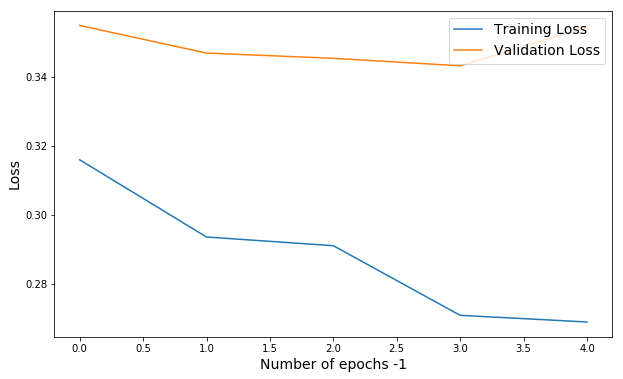

In [43]:
train_loss=history5.history['loss']
val_loss=history5.history['val_loss']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend(loc="upper right", fontsize=14)

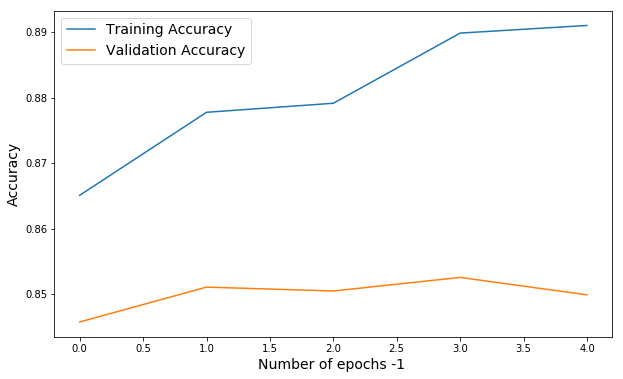

In [44]:
train_acc=history5.history['acc']
val_acc=history5.history['val_acc']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
ax.set_xlabel("Number of epochs -1 ", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.legend(loc="upper left", fontsize=14)

The problem now is that the network learns too slowly: the training curves end up improving vey slowly. As for validation, training simply stops. This may also indicate overfitting. Let us try to speed up learning a bit and add Dropout with Batch Normalization.

In [56]:
inputs=tf.keras.Input(shape=(96, 96, 3))
x1a=tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3))(inputs)
x2a=tf.keras.layers.MaxPooling2D(2, 2)(x1a)
x3a=tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x2a)
x4a=tf.keras.layers.MaxPooling2D(2, 2)(x3a)
x5a=tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x4a)
x6a=tf.keras.layers.MaxPooling2D(2, 2)(x5a)
x7a=tf.keras.layers.Flatten()(x6a)
x1b=tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3))(inputs)
x2b=tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x1b)
x3b=tf.keras.layers.MaxPooling2D(2, 2)(x2b)
x4b=tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x3b)
x5b=tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x4b)
x6b=tf.keras.layers.MaxPooling2D(2, 2)(x5b)
x7b=tf.keras.layers.Flatten()(x6b)
x8=tf.keras.layers.Concatenate(axis=1)([x7a,x7b])
x9=tf.keras.layers.BatchNormalization()(x8)
x10=tf.keras.layers.Dropout(0.5)(x9)
x11=tf.keras.layers.Dense(512, activation='relu')(x10)
x12=tf.keras.layers.BatchNormalization()(x11)
x13=tf.keras.layers.Dropout(0.5)(x12)
outputs=tf.keras.layers.Dense(1, activation='sigmoid')(x13)

model2=tf.keras.Model(inputs=inputs,outputs=outputs)
model2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.000025), loss='binary_crossentropy', metrics=['acc'])
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 94, 94, 16)   448         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 94, 94, 16)   448         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_26 (MaxPooling2D) (None, 47, 47, 16)   0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_40 

In [57]:
history5=model2.fit_generator(generator=train_generator,steps_per_epoch=m_train//batch_size,epochs=20,verbose=1,shuffle=True,
                            validation_data=(val_data,l_val),validation_steps=5)

Epoch 1/20
1692/1692 [==============================] - 225s 133ms/step - loss: 0.5582 - acc: 0.7645 - val_loss: 0.4117 - val_acc: 0.8287
Epoch 2/20
1692/1692 [==============================] - 224s 132ms/step - loss: 0.4685 - acc: 0.8016 - val_loss: 0.4056 - val_acc: 0.8236
Epoch 3/20
1692/1692 [==============================] - 224s 132ms/step - loss: 0.4269 - acc: 0.8187 - val_loss: 0.3929 - val_acc: 0.8337
Epoch 4/20
1692/1692 [==============================] - 225s 133ms/step - loss: 0.4098 - acc: 0.8261 - val_loss: 0.3995 - val_acc: 0.8319
Epoch 5/20
1692/1692 [==============================] - 224s 133ms/step - loss: 0.3906 - acc: 0.8339 - val_loss: 0.3936 - val_acc: 0.8369
Epoch 6/20
1692/1692 [==============================] - 224s 132ms/step - loss: 0.3798 - acc: 0.8382 - val_loss: 0.3762 - val_acc: 0.8411
Epoch 7/20
1692/1692 [==============================] - 225s 133ms/step - loss: 0.3635 - acc: 0.8448 - val_loss: 0.3807 - val_acc: 0.8334
Epoch 8/20
1692/1692 [============

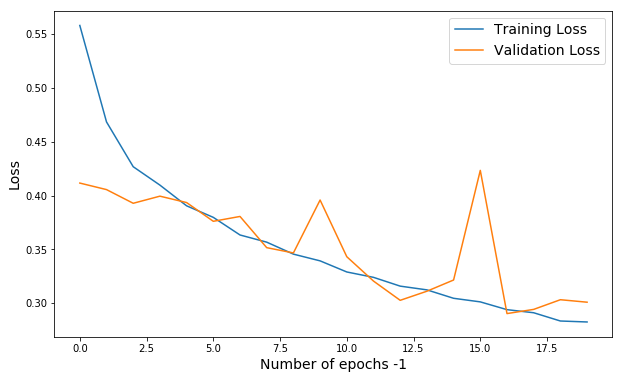

In [58]:
train_loss=history5.history['loss']
val_loss=history5.history['val_loss']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend(loc="upper right", fontsize=14)

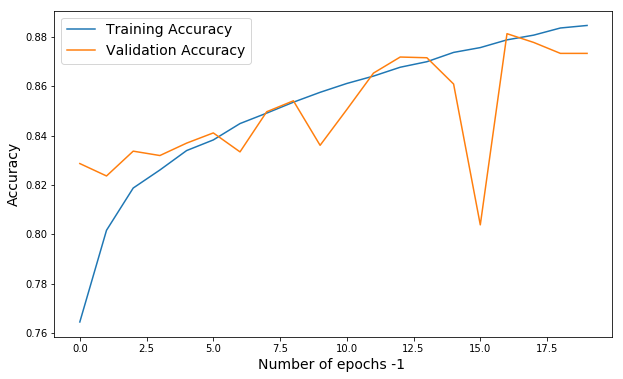

In [59]:
train_acc=history5.history['acc']
val_acc=history5.history['val_acc']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
ax.set_xlabel("Number of epochs -1 ", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.legend(loc="upper left", fontsize=14)

The validation curves are jagged and the low learning rate makes learning just too slow. It is worse than the first model.

In [70]:
ypp=model2.predict(val_data)[:,0]
# From the history, we get the validation accuracy in the end of training
#measurements[1,0]=history5.history['val_acc'][19]
#measurements[1,0]=np.mean(np.float32(np.equal(np.int32(ypp+0.5),l_val)))
print(measurements[1,0])

0.8732644016316582


Text(0.4,0.2,'AUC: 0.9464861821280739')

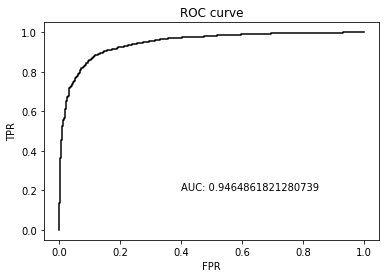

In [71]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr,tpr,thresholds = roc_curve(l_val,ypp)
auc=roc_auc_score(l_val,ypp)
plt.plot(fpr,tpr,'k-')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.4,0.2,'AUC: '+str(auc))

In [69]:
#measurements[1,1]=auc

Let's get the test score from Kaggle.

In [60]:
ypp=np.zeros([m_test])
X_test_im_names=np.array(test_im_names)
for batch in range(m_test//batch_size):
    batch_im=X_test_im_names[batch*batch_size:(batch+1)*batch_size]
    current_batch=np.array([np.reshape(plt.imread('test/'+im_name),[96,96,3]) for im_name in batch_im])/255.0
    ypp[batch*batch_size:(batch+1)*batch_size]=model2.predict(current_batch)[:,0]
batch=m_test//batch_size
batch_im=X_test_im_names[batch*batch_size:m_test]
current_batch=np.array([np.reshape(plt.imread('test/'+im_name),[96,96,3]) for im_name in batch_im])/255.0
ypp[batch*batch_size:m_test]=model2.predict(current_batch)[:,0]

In [61]:
df_test=pd.read_csv("sample_submission.csv")
csv_preds=get_csv_preds(test_im_names,df_test,ypp)
df_y_test = pd.DataFrame(csv_preds,index=np.arange(len(df_test)),columns=['label'])
test_pred_df=pd.DataFrame(pd.concat([df_test.id,df_y_test],axis=1),index=df_test.index)
test_pred_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.048666
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.266800
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.001998
3,2c35657e312966e9294eac6841726ff3a748febf,0.109966
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.033558


In [102]:
#Save the files to the hard drive
#test_pred_df.to_csv('Lymph_Node_Invasion_my_2nd_solutionV2.csv',index=False)
# Clear the memory for the new iteration
#del df_y_test
#del df_test
#del test_pred_df
histories5=np.array([history5.history['loss'],history5.history['val_loss'],
                        history5.history['acc'],history5.history['val_acc']])
#np.save('histories5.npy',histories5)

In [2]:
#measurements[1,2]=0.8756*0.51+0.9100*0.49
#print(measurements[1,2])

0.892456


Kaggle returned a worse score. Let us try one more iteration.

### Third iteration

This strategy of putting two networks side by side did not work well. The new network required an even lower initial learning rate and even though it may have appeared to overfit, because the validation loss would plateau, adding more data, Dropout and Batch Normalization did not improve the results.

So let us go back to basics: let us try brute force. We will use the initial model, but simply increase the number of kernels in each layer, and the size of the output layer. Since the initial model did not overfit, we will not use augmented data with this larger model.

In [90]:
batch_size=64
train_generator=iter(MyGenerator(X_train_im_names,l_train,batch_size))

In [91]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1048, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model3.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.00005), loss='binary_crossentropy', metrics=['acc'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 12800)             0         
__________

In [92]:
history6=model3.fit_generator(generator=train_generator,steps_per_epoch=m_train//batch_size,epochs=20,verbose=1,shuffle=True,
                            validation_data=(val_data,l_val),validation_steps=5)

Epoch 1/20
3385/3385 [==============================] - 169s 50ms/step - loss: 0.4467 - acc: 0.7958 - val_loss: 0.4107 - val_acc: 0.8162
Epoch 2/20
3385/3385 [==============================] - 167s 49ms/step - loss: 0.3725 - acc: 0.8355 - val_loss: 0.3438 - val_acc: 0.8526
Epoch 3/20
3385/3385 [==============================] - 167s 49ms/step - loss: 0.3356 - acc: 0.8553 - val_loss: 0.3204 - val_acc: 0.8679
Epoch 4/20
3385/3385 [==============================] - 168s 50ms/step - loss: 0.3123 - acc: 0.8670 - val_loss: 0.3044 - val_acc: 0.8744
Epoch 5/20
3385/3385 [==============================] - 168s 50ms/step - loss: 0.2946 - acc: 0.8762 - val_loss: 0.2904 - val_acc: 0.8830
Epoch 6/20
3385/3385 [==============================] - 169s 50ms/step - loss: 0.2804 - acc: 0.8832 - val_loss: 0.2832 - val_acc: 0.8848
Epoch 7/20
3385/3385 [==============================] - 169s 50ms/step - loss: 0.2683 - acc: 0.8898 - val_loss: 0.2762 - val_acc: 0.8869
Epoch 8/20
3385/3385 [===================

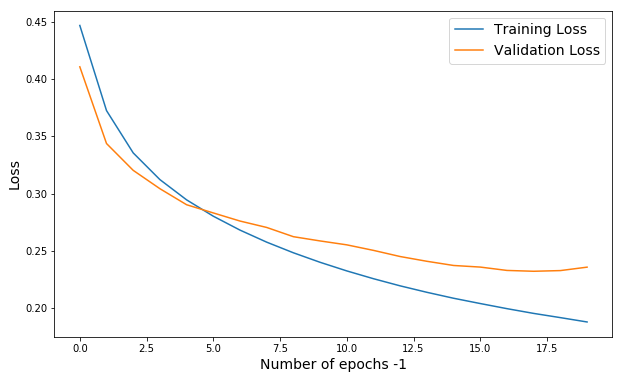

In [93]:
train_loss=history6.history['loss']
val_loss=history6.history['val_loss']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend(loc="upper right", fontsize=14)

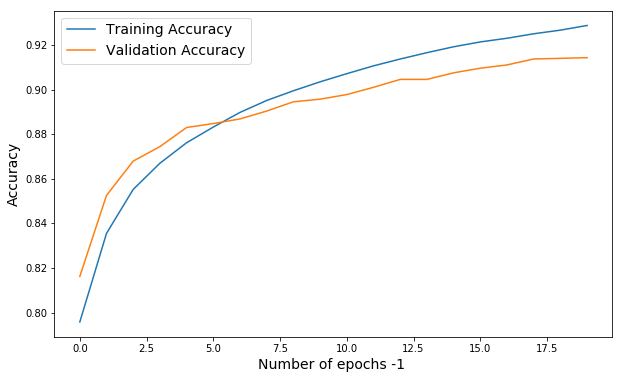

In [95]:
train_acc=history6.history['acc']
val_acc=history6.history['val_acc']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
ax.set_xlabel("Number of epochs -1 ", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.legend(loc="upper left", fontsize=14)

Increasing the number of filters does not lead to overfitting as shown by examining the learning curves, perhaps because of the use of augmented data. It does improve performance.


In [96]:
ypp=model3.predict(val_data)[:,0]
# From the history, we get the validation accuracy in the end of training
measurements[2,0]=history6.history['val_acc'][19]
#measurements[2,0]=np.mean(np.float32(np.equal(np.int32(ypp+0.5),l_val)))
print(measurements[2,0])

0.9143279170180001


Text(0.4,0.2,'AUC: 0.9688097846881629')

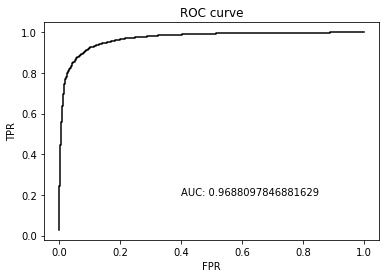

In [97]:
#from sklearn.metrics import roc_curve,roc_auc_score

fpr,tpr,thresholds = roc_curve(l_val,ypp)
auc=roc_auc_score(l_val,ypp)
plt.plot(fpr,tpr,'k-')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.4,0.2,'AUC: '+str(auc))

In [98]:
#measurements[2,1]=auc

Let's get the test score from Kaggle.

In [99]:
ypp=np.zeros([m_test])
X_test_im_names=np.array(test_im_names)
for batch in range(m_test//batch_size):
    batch_im=X_test_im_names[batch*batch_size:(batch+1)*batch_size]
    current_batch=np.array([np.reshape(plt.imread('test/'+im_name),[96,96,3]) for im_name in batch_im])/255.0
    ypp[batch*batch_size:(batch+1)*batch_size]=model3.predict(current_batch)[:,0]
batch=m_test//batch_size
batch_im=X_test_im_names[batch*batch_size:m_test]
current_batch=np.array([np.reshape(plt.imread('test/'+im_name),[96,96,3]) for im_name in batch_im])/255.0
ypp[batch*batch_size:m_test]=model3.predict(current_batch)[:,0]

In [100]:
df_test=pd.read_csv("sample_submission.csv")
csv_preds=get_csv_preds(test_im_names,df_test,ypp)
df_y_test = pd.DataFrame(csv_preds,index=np.arange(len(df_test)),columns=['label'])
test_pred_df=pd.DataFrame(pd.concat([df_test.id,df_y_test],axis=1),index=df_test.index)
test_pred_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,1.062557e-02
1,95596b92e5066c5c52466c90b69ff089b39f2737,3.841777e-01
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,1.101230e-08
3,2c35657e312966e9294eac6841726ff3a748febf,7.595150e-04
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,9.791087e-02


In [101]:
#Save the files to the hard drive
#test_pred_df.to_csv('Lymph_Node_Invasion_my_3rd_solutionV2.csv',index=False)
# Clear the memory for the new iteration
del df_y_test
del df_test
del test_pred_df
histories6=np.array([history6.history['loss'],history6.history['val_loss'],
                        history6.history['acc'],history6.history['val_acc']])
#np.save('histories6.npy',histories6)

In [5]:
#measurements[2,2]=0.8659*0.51+0.9442*0.49
#print(measurements)

[[0.88360414 0.95377814 0.905883  ]
 [0.8732644  0.94648618 0.892456  ]
 [0.91432792 0.96880978 0.904267  ]]


In [4]:
#Save the file to the hard drive
#test_pred_df.to_csv('Lymph_Node_Invasion_my_3rd_solution.csv',index=False)
#np.save('measurements.npy',measurements)

This last iteration produced better results. The model's validation accuracy and AUC of the ROC curve were both a bit better. 

So, we decided to submit to Kagle: the result was a test score of: 0.888098

## Step 4: Results

Below is a recapitulation of the hyperparameter search for the optimizer and the learning rate in the first iteration. The Adam optimizer was tried, but the training loss was not a number and the training accuracy would decrease even when starting with low learning rates. Learning curves were not inspected. We opted for RMSprop.

The selection of the learning rate with RMSProp was made by visual inspection of the learning curves, displayed again below for memory. 

In [128]:
#init_histories=np.load('init_histories.npy')

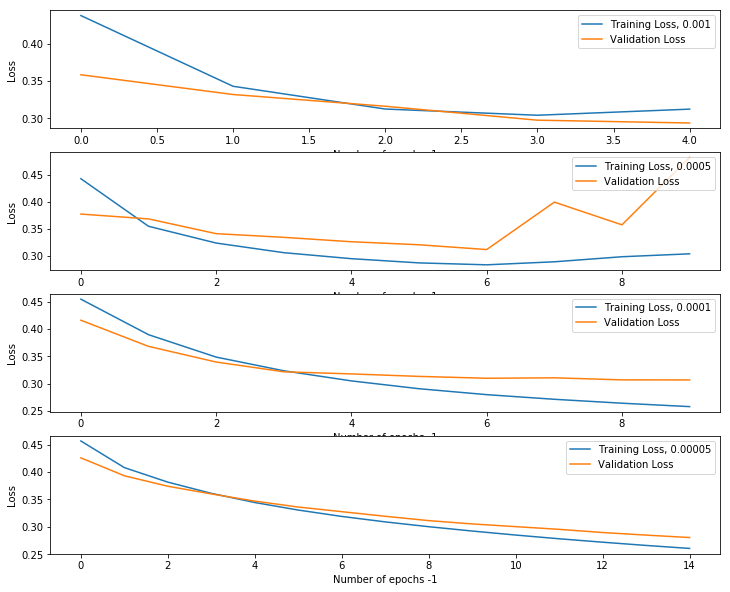

In [125]:
hists=[init_histories[:,:5]]
hists.append(init_histories[:,5:15])
hists.append(init_histories[:,15:25])
hists.append(init_histories[:,25:40])
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12,10))
learning_rates=["0.001","0.0005","0.0001","0.00005"]
for idx in range(4):
    axs[idx].plot(hists[idx][0],label='Training Loss, '+learning_rates[idx])
    axs[idx].plot(hists[idx][1],label='Validation Loss')
    axs[idx].set_xlabel("Number of epochs -1", fontsize=10)
    axs[idx].set_ylabel("Loss", fontsize=10)
    axs[idx].legend(loc="upper right", fontsize=10)

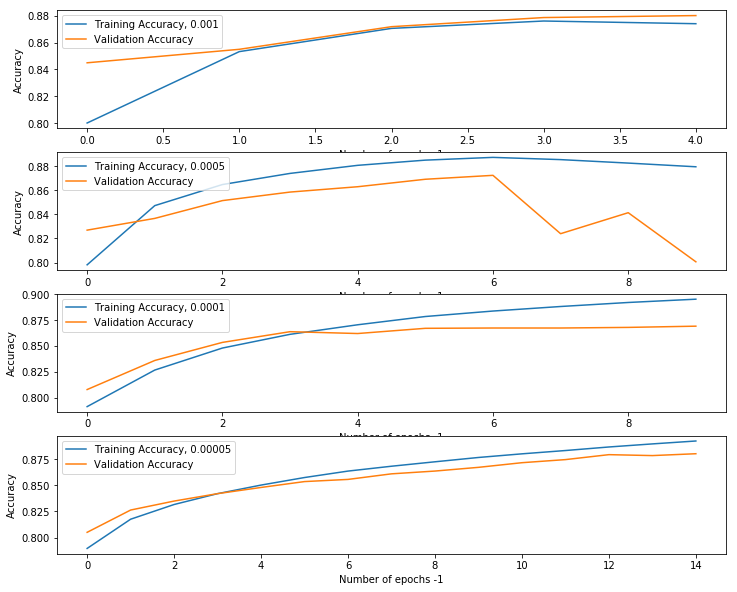

In [127]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12,10))
for idx in range(4):
    axs[idx].plot(hists[idx][2],label='Training Accuracy, '+learning_rates[idx])
    axs[idx].plot(hists[idx][3],label='Validation Accuracy')
    axs[idx].set_xlabel("Number of epochs -1", fontsize=10)
    axs[idx].set_ylabel("Accuracy", fontsize=10)
    axs[idx].legend(loc="upper left", fontsize=10)

What these curves showed, was that initial learning rates of 0.001 and 0.0005 were to high, because the validation loss tended to fluctuate a lot with no clear pattern of diminishing. With an initial learning rate of 0.0001, the validation accuracy curve tended to plateau early, indicating it was also too high. So we opted for an initial learning rate of 0.00005.

After training the initial model, there was no evidence of overfitting. On the other hand, this model had a high bias. A medical test developed with it would have missed 10% of cancers with a false positive cutoff around 20%, based on looking at the ROC curve. So we built a second model with more parameters: basically two convolutional networks placed side by side, with a classifer using the best of the two.

Below is a table summarizing the results of the models tested, in term of validation accuracy and ROC, and the scores returned by Kaggle.

In [6]:
print("Summary of Architectures Tried")
column_labels=['Validation Accuracy','Area Under the ROC','Kaggle test score']
index_labels=['3 Conv2+MaxPooling + Classifer','Joined Conv Nets, Batch Norm, Dropout + Augmented Data',
              'Same as first but bigger']
df_training_accs=pd.DataFrame(measurements[:,:],index=index_labels,columns=column_labels)
df_training_accs.head()

Summary of Architectures Tried


,Validation Accuracy,Area Under the ROC,Kaggle test score
3 Conv2+MaxPooling + Classifer,0.883604,0.953778,0.905883
"Joined Conv Nets, Batch Norm, Dropout + Augmented Data",0.873264,0.946486,0.892456
Same as first but bigger,0.914328,0.968810,0.904267


The architecture of the first model consisted of a feature extractor made of 3 modules: Conv2D+Maxpooling, followed, after flattening the output, by a classifier with one dense hidden layer and one sigmoid output layer. It was trained using RMSProp with an initial learning rate of 0.00005, with the binary crossentropy to correspond to the sigmoid output. It produced a validation accuracy around 88%, an AUC under the ROC curve around 95% and a Kaggle score on the test sample around 0.87. It did not suffer from overfitting, but from high bias: it was not good enough in practice for a medical test: for example, looking at the ROC curve, with a false positive rate around 20%, the test would miss about 10% of cancers!

In order to attempt to improve the lack of expressivity of this first model, we used a larger architure. Specifically, we used two feature extractors with different arrangements of convolutional layers and pooling layers arranged in parallel, followed by a classifier. The first feature extractor was identical to that of the first model. The second was made of two modules consisting of two Convolutional layers (16 and 32 filters for the first, 32 and 64 filters for the second) followed by a MaxPooling layer of 2 by 2. We added Batch Normalization to scale the features at the entry of the classifier. This model performed poorly: the validation curves diverged. So a smaller learning rate was used, but then the model was learning too slowly. As the poor learning could have been due to early overfitting, we added Dropout on the classifier layers, with Batch Normalization added prior to Dropout. The model performed more poorly compared to the initial one. 

So we tried to simply enlarge the first model, using more filters and a larger hidden layer for the classifier. It did not need augmented data, it did not show overfitting either and had a better performance. Looking at the ROC curve used with validation data, a false positive cutoff of 20% now only misses about 5% of cancers. Almost good enough for a medical test! Kaggle did not return a better ROC score than the first try though!



## Step 5: Conclusion

With this notebook, we attempted to train from scratch convolutional network models in order to classify histological samples into those showing cancer invasion and those not showing it. It turned out that attempts to make the model more complex did not help and we even resorted to brute force to try to improve performance. In the end I would not have wanted my wife's surgeon to use my test, if need be. Other Kaggle contenders have been able to perfectly classify the samples, with 0 false negatives on the test set.

As underlined above, the approach chosen here was to train a convolutional network from scratch. An alternative approach would have been to use a very deep network such as Inception or ResNet, keep the feature extractor part with frozen weights, but to add a different classifier on top of it, the latter being trainable. This will have to be the topic of another challenge.

#### Bibliography

[1] Rajat Garg (2019). Training on large datasets that don't fit in memory in Keras. Medium.com
https://medium.com/@mrgarg.rajat/training-on-large-datasets-that-dont-fit-in-memory-in-keras-609974785d71

[2] Laurence Moroney (2019). Convolutional Networks in Tensorflow. Deeplearning.ai.
https://www.coursera.org/learn/convolutional-neural-networks-tensorflow

[3] Will Kukiersk (2018). Histopathologic Cancer Detection. Kaggle https://kaggle.com/competitions/histopathologic-cancer-detection